In [46]:
# Barren Plateaus Data Analysis

## Load Data

import matplotlib as mpl
mpl.rc("savefig", dpi=500)
%matplotlib inline

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import glob
import ast

data_path = '/home/gbarron/data/bps/maxcut/'
sns.set_palette('viridis', n_colors=100)

def array_interpret(s: str) -> np.array:
    try:
        return np.array(ast.literal_eval(f'[{s}]'))[0]
    except:
        return np.array([])

def interpret_complex(s:str) -> float:
    if '+' in s:
        re, im = s.split('+')
        re = float(re)
        im = im.rstrip(" ")[0:-2]
        im = float(im)
        if abs(im) > 0.0:
            raise ValueError("Non-zero imaginary component!!!")
    else:
        re = float(s)
    return re

def gate_counts(l):
    n = len(l[0])
    return Counter(map(lambda s: n - s.count("I"), l))

""" `df_layerwise` contains information collected during the inner loop (VQE
subroutine) of ADAPT-VQE.
"""

df_layerwise = None

for file_path in glob.glob(data_path+'**/layer_*.csv', recursive=True):
    _, _, _, _, _, ham, num_qubits, pool, seed, layer = file_path.split("/")
    num_qubits = int(num_qubits)
    seed = int(seed)
    layer = int(layer.split("_")[1].split(".")[0])
    
    _df_layerwise = pd.read_csv(
            file_path,
            delimiter=';',
            converters={
                'iter': int,
                ' cost': float,
                ' point': array_interpret,
                ' grad': array_interpret}
        )
    _df_layerwise['num_qubits'] = num_qubits
    _df_layerwise['seed'] = seed
    _df_layerwise['layer'] = layer
    
    if df_layerwise is None:
        df_layerwise = _df_layerwise
    else:
        df_layerwise = pd.concat([df_layerwise, _df_layerwise])
df_layerwise.rename(columns=lambda x: x.lstrip(' '), inplace=True)
#df_layerwise.drop('point', inplace=True, axis=1)

groups = []

for name, group in df_layerwise.groupby(['num_qubits', 'seed']):
    num_qubits, seed = name
    num_layers = max(group['layer'])
    group['final_layer'] = group['layer'].map(lambda l: l == num_layers)
    groups.append(group)
df_layerwise = pd.concat(groups).reset_index()

""" `df_result` contains information about the final convergence properties
of ADAPT-VQE. This includes information about the success of the ADAPT-VQE
algorithm.

`df_adapt` contains information collected during the outer loop of
ADAPT-VQE, for example gradients computed and operators selected, etc.
"""


df_result = None
df_adapt = None

for exact_file_path in glob.glob(data_path+'**/exact_result.csv', recursive=True):
    _, _, _, _, _, ham, num_qubits, pool, seed, _ = exact_file_path.split("/")
    adapt_file_path = exact_file_path.split('exact')[0] + 'adapt_history.csv'
    num_qubits = int(num_qubits)
    seed = int(seed)
    
    _df_result_1 = pd.read_csv(exact_file_path, delimiter=';', converters={
        ' min_bs': str, ' min_val': interpret_complex})
    try:
        _df_result_2 = pd.read_csv(adapt_file_path, delimiter=';')
    except:
        continue
    _df_result_1.rename(columns=lambda x: x.lstrip(' '), inplace=True)
    _df_result_2.rename(columns=lambda x: x.lstrip(' '), inplace=True)
    
    _df_result_1['num_qubits'] = num_qubits
    _df_result_1['seed'] = seed
    _df_result_1['min_bs'] = _df_result_1['min_bs'].map(lambda bs: bs.rjust(num_qubits, '0'))
    
    #####################
    # Process Pauli lists
    if len(_df_result_1) > 1:
        raise ValueError("Hmm...")
    _df_result_1['pauli_list'] = [None] * len(_df_result_1)
    _df_result_1['pauli_list'] = [list(map(lambda s: s.lstrip(), list(_df_result_2['paulis'])))]
    _df_result_1['two_local_op_count'] = _df_result_1['pauli_list'].map(lambda g: gate_counts(g)[2])
    #####################
    
    _df_adapt = pd.concat([pd.concat([_df_result_1]*len(_df_result_2), ignore_index=True), _df_result_2], axis=1, )
    
    if df_adapt is None:
        df_adapt = _df_adapt
    else:
        df_adapt = pd.concat([df_adapt, _df_adapt])
    
df_adapt.reset_index(inplace=True)
df_adapt.drop(columns='index', inplace=True)
df_adapt = df_adapt[df_adapt['opt_numevals'] != ' nothing']
df_adapt['grads'] = df_adapt['grads'].map(array_interpret)
df_adapt['opt_pars'] = df_adapt['opt_pars'].map(array_interpret)
df_adapt['opt_numevals'] = df_adapt['opt_numevals'].map(int)
df_adapt['norm_c'] = df_adapt['energy'] / df_adapt['min_val']


for name, group in df_adapt.groupby(['num_qubits', 'seed']):
    num_qubits, seed = name
    num_layers = max(group['layer'])
    group = group[group['layer'] == num_layers]
    if df_result is None:
        df_result = group
    else:
        df_result = pd.concat([group, df_result])

df_adapt.drop(columns=['pauli_list', 'two_local_op_count'], inplace=True)

df_adapt['num_qubits'].value_counts()

df_result['num_qubits'].value_counts()

df_layerwise['num_qubits'].value_counts()

# Plots

## Approximation Ratio

This plot demonstrates the success of the ADAPT-VQE algorithm on the family of max cut Hamiltonians. The y axis is the approximation ratio, which measures performance. It is calculated by taking the value of the cost function determined by the algorithm and dividing by the exact answer. This means that `1.0` is a perfect result.

We can see that for all numbers of qubits considered, the approximation ratio goes roughly to `1.0`. This means that on average, the algorithm succeeds with sufficiently many layers of ADAPT.

It is natural to ask: How many layers is sufficient to converge, as a function of the number of qubits?

(Compare with Fig 5 https://arxiv.org/pdf/2004.04197.pdf)

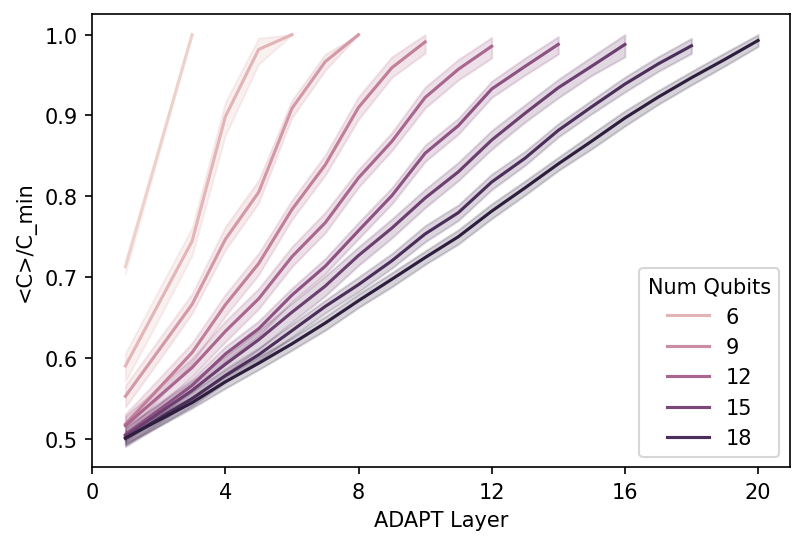

In [107]:
ax = sns.lineplot(data=df_adapt, x='layer', y='norm_c', hue='num_qubits')
#ax = sns.scatterplot(data=df_adapt, x='layer', y='norm_c', hue='num_qubits')
ax.set_xlabel("ADAPT Layer")
ax.set_ylabel("<C>/C_min")
ax.set_xticks(np.arange(0, 20+1, step=4))
ax.legend(title="Num Qubits", loc='lower right');

## Layers to Convergence

Now we can take the above data and consider only the approximation ratio at final layer of ADAPT, i.e. the actual result. As a function of the number of qubits, the number of layers needed to converge ADAPT fits well to a linear regression. The implication of this result is that for the setup considered, ADAPT requires circuits of depth `O(n)`.

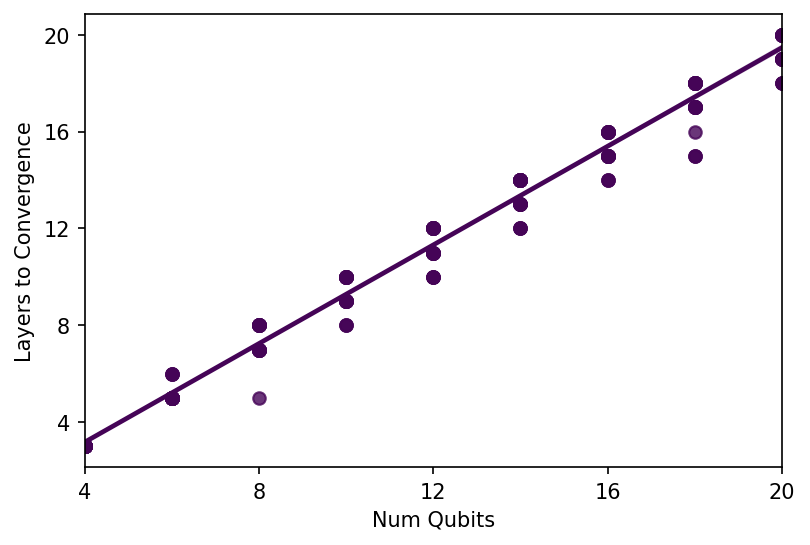

In [123]:
ax = sns.regplot(data=df_result, x='num_qubits', y='layer')
ax.set_xlabel("Num Qubits")
ax.set_ylabel("Layers to Convergence")
ax.set_xticks(np.arange(4, 20+1, step=4))
ax.set_yticks(np.arange(4, 20+1, step=4));

## Detail of Approximation Ratio

Now let's take a closer look at the final value of the approximation ratio. Here we consider the final result as a function of the number of qubits. There are two plots on this figure, both representing the same information. The solid line with the shaded region are the mean of the approximation ratio for that number of qubits and the 95% confidence interval for the data, respectively. The dots are the raw data.

This plot tells us that on average, the approximation ratio consistently stays above `0.9`. However, there are some exceptions to this statement for larger numbers of qubits. More interestingly, there seem to be three clusters of data. I do not yet have an explanation for this.

It is important to note that there are many dots clustered around and approximation ratio of `1.0`. For example, for 20 qubits, 60% of the data are at an approximation ratio of `1.0`.

(Compare with Fig 4 https://arxiv.org/pdf/2004.04197.pdf)

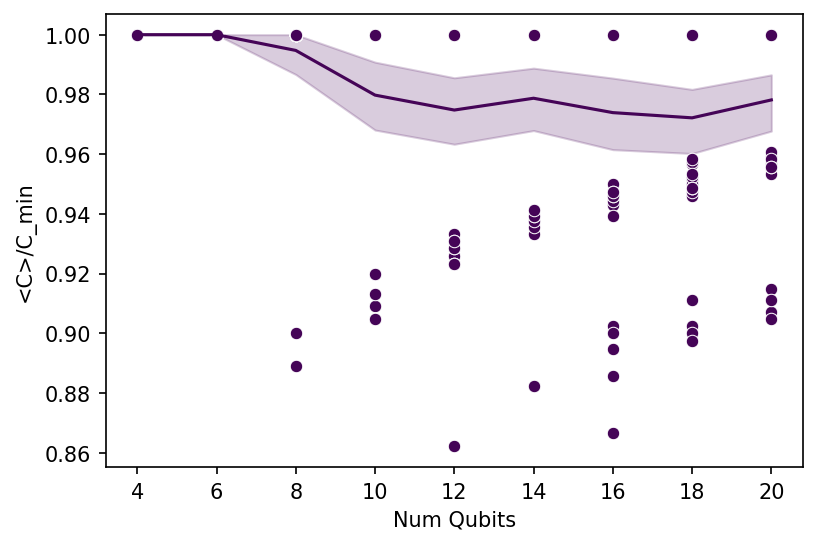

In [124]:
ax = sns.lineplot(data=df_result, x='num_qubits', y='norm_c')
ax = sns.scatterplot(data=df_result, x='num_qubits', y='norm_c')
#ax = sns.boxplot(data=df_result, x='num_qubits', y='norm_c', whis=np.inf)
ax.set_xlabel("Num Qubits")
ax.set_ylabel("<C>/C_min");
#ax.set_xticks(np.arange(0, 20+1, step=4));
#ax.set_ylim(0, 1)

## Circuit Depth

As another performance check, we can ask how many 2-local operators are being chosen to reach a given approximation ratio. This is important because the current form of the ansatz does not have the QAOA structure, so there is no direct comparison with the value of `p` in the algorithm. Hence, we count the number of 2-local operators.

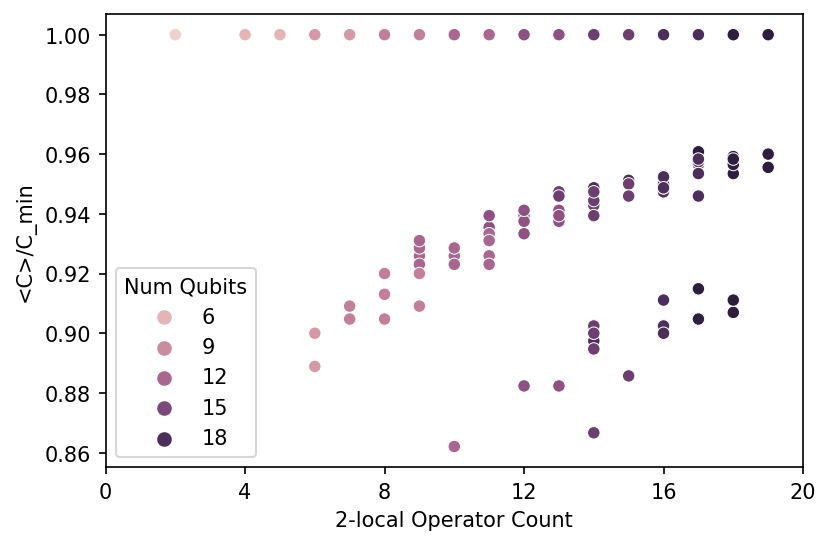

In [126]:
#ax = sns.lineplot(data=df_result, x='two_local_op_count', y='norm_c', hue='num_qubits')
ax = sns.scatterplot(data=df_result, x='two_local_op_count', y='norm_c', hue='num_qubits')
ax.set_xlabel("2-local Operator Count")
ax.set_ylabel("<C>/C_min")
ax.set_xticks(np.arange(0, 20+1, step=4))
ax.legend(title="Num Qubits", loc='lower left');

## Gradient Convergence

In all following discussion, when we refer to values of the gradient we are referring to the **components** of the gradient, rather than the norm of the gradient vector.

Thusfar, the results have been focused on understanding the convergence of the ADAPT for this particular problem. These results are interesting in their own rite (specifically the observation that ADAPT converges in `O(n)` layers), however we are also interested in understanding the effect (or lack thereof) of barren plateaus on the ADAPT algorithm.

To this end, we begin by showing the gradients computed **during the inner loop VQE optimization** as a function of each layer of ADAPT. Note that this is **not** displaying the `~<[H,O]>` gradients computed in the **outer loop**.

From this plot we can see that the gradients generally decrease in magnitude as the number of layers increases, however, we are interested in the asymptotic behavior of the gradients and their variance.

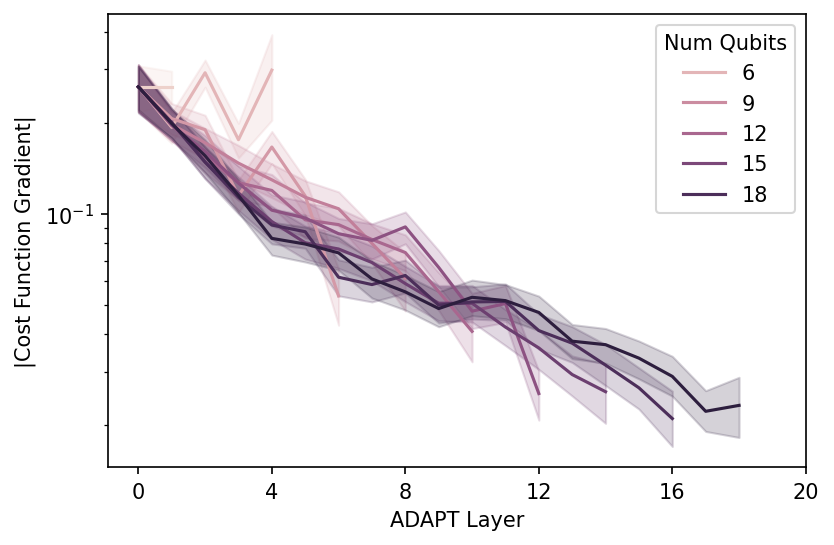

In [140]:
"""This plot shows components of the gradient calculated during
the inner loop (VQE subroutine) of ADAPT-VQE, as a function of the
number of layers and number of qubits.

For each number of qubits, the gradient converges at some number of
layers. Visually, the number of layers required to converge seems to
increase linearly with the number of qubits. This is significant
because it is numerical evidence that (for the max cut problem and
2-local pool), ADAPT-VQE requires `O(n)` layers to converge.
"""
_df_layerwise = df_layerwise.explode('grad')
_df_layerwise.grad = _df_layerwise.grad.astype(float)
_df_layerwise.grad = _df_layerwise.grad.map(abs)
ax = sns.lineplot(data=_df_layerwise, x='layer', y='grad', hue='num_qubits')
ax.set_xlabel("ADAPT Layer")
ax.set_ylabel("|Cost Function Gradient|")
ax.set_yscale('log')
ax.set_xticks(np.arange(0, 20+1, step=4))
ax.legend(title="Num Qubits", loc='upper right');

## CDF Gradient Analysis

To better understand the distributions of the gradients, we will focus on the gradients computed (again, during the **inner VQE loop**) at the final layer of ADAPT.

We plot the cumulative distribution function (CDF) of the gradients computed for varying numbers of qubits. The cumulative distribution function (each line on the plot) represents the proportion (the y axis) of the data that fall below each given value on the x axis. Hence, the lines are monotonically increasing, and all have a limit `1.0` as the x axis increases.

The trend in the CDFs as a function of the number of qubits is that they tend to shift to the left as the number of qubits increases. From the last figure, this result is expected. However, we want to know _how quickly_ this happens.

We can see that although the CDFs shift to the left as a function of the number of qubits, they tend to bunch up closer together as the number of qubits increases. **(I am still thinking about the conclusions of this plot)**

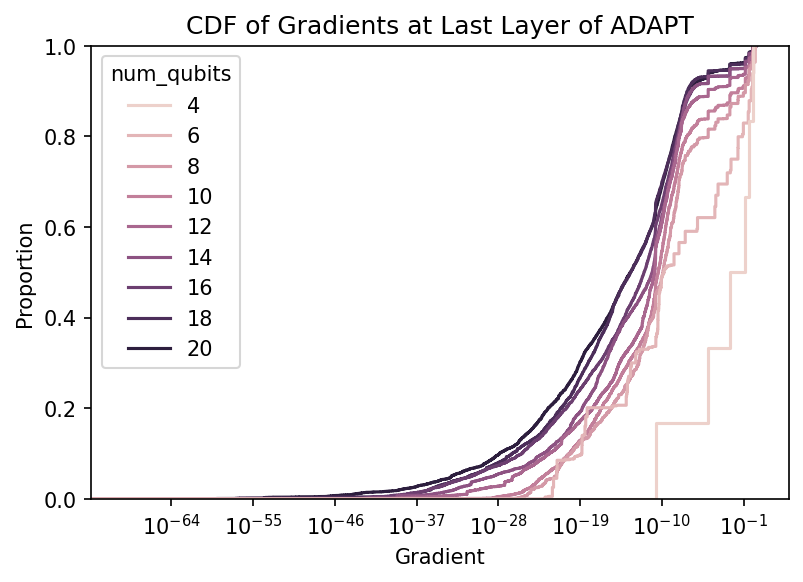

In [173]:
ax = sns.ecdfplot(data=_df_layerwise[_df_layerwise['final_layer'] == True], x='grad', hue='num_qubits')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel("Gradient")
ax.set_title("CDF of Gradients at Last Layer of ADAPT");
#ax.set_xlim(1e-19, 1);

## Variance of Gradient Analysis

Finally, the most common method of investigating barren plateaus is by analyzing the variance of the gradient as a function of the number of qubits. If the variance decays as a function of the number of qubits slower than exponentially, then we can say that barren plateaus are mitigated by ADAPT.

It is currently not clear whether or not this is the case.

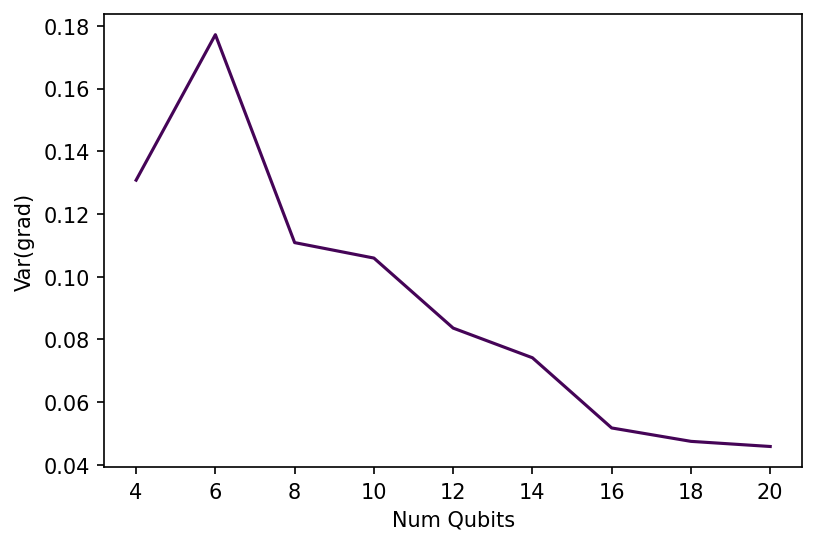

In [172]:
ax = sns.lineplot(
    data=_df_layerwise.groupby(by=['num_qubits']).aggregate('var').reset_index(),
    x='num_qubits',
    y='grad'
)
ax.set_ylabel("Var(grad)")
ax.set_xlabel("Num Qubits");
#ax.set_yscale("log");